In [1]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('bmh')
# print(plt.style.available)
import statsmodels.api as sm

In [2]:
df_ati_anonimo = pd.read_excel('data/Ati_anonimo.xlsx')
#print(df_ati_anonimo.info())

df = pd.DataFrame(columns=["DNI", "COMISION", "SEGUIMIENTO 1", "SEGUIMIENTO 2", "SEGUIMIENTO 3", "SEGUIMIENTO 4", "NOTA DE ANONIMO"])
print(f"Number of people in anonimo file before drop duplicates: {len(df_ati_anonimo)}")
df["DNI"] = df_ati_anonimo.drop_duplicates(subset=['DNI', 'COMISION', 'NOTA'], keep=False)["DNI"].values
print(f"Number of people in anonimo file after drop duplicates: {len(df['DNI'])}")
df["DNI"] = df["DNI"].apply(lambda x: int(str(x).replace(".", "").replace(" ", "")))
df["COMISION"] = df_ati_anonimo.drop_duplicates(subset=['DNI', 'COMISION', 'NOTA'], keep=False)["COMISION"].values
df["NOTA DE ANONIMO"] = df_ati_anonimo.drop_duplicates(subset=['DNI', 'COMISION', 'NOTA'], keep=False)["NOTA"].values

number_of_people_not_in_anonimo = 0

for seguimiento in range(1, 5):
    files_in_folder = os.listdir(f"data/Actividades de Seguimiento/Actividad de Seguimiento {seguimiento}")
    for file in files_in_folder:
        if file.endswith(".xlsx"):
            df_file = pd.read_excel(f"data/Actividades de Seguimiento/Actividad de Seguimiento {seguimiento}/{file}")
            match = re.search(r'\((.*?)\)', file)
            if match:
                comision = match.group(1)
                for index, row in df_file.iterrows():
                    dni = row["Número de ID"]
                    points = float(str(row["Calificación/10,00"]).replace(",", "."))
                    if re.search(r'[a-zA-Z]', str(dni)):
                        # check if nan
                        if not pd.isna(dni):
                            print(f"File {file} contains non-numeric, non-nan DNI value {dni}.")
                    else:
                        dni = int(dni)
                        if df[(df["DNI"] == dni) & (df["COMISION"] == comision)].empty:
                            number_of_people_not_in_anonimo += 1
                            # If the dni is not in the anonimo file, add it to the df
                            df = pd.concat([df, pd.DataFrame([{"DNI": dni, "COMISION": comision, f"SEGUIMIENTO {seguimiento}": points}])], ignore_index=True)
                        else:
                            df.loc[(df["DNI"] == dni) & (df["COMISION"] == comision), f"SEGUIMIENTO {seguimiento}"] = points
            else:
                print(f"File {file} does not contain a commission number.")

df["Number of Approved"] = df.apply(lambda x: sum(x[f"SEGUIMIENTO {i}"] >= 6 for i in range(1, 5)), axis=1)
df["Number of Hecho"] = df.apply(lambda x: 4 - sum([pd.isna(x[f"SEGUIMIENTO {i}"]) for i in range(1, 5)]), axis=1)
df["Ventaje"] = df.apply(lambda x: (x["Number of Approved"] >= 2) & (x["Number of Hecho"] >= 3), axis=1)

map_aprobado_to_bin = {"Aprobado": 1, "Desaprobado": 0, "Ausente": np.nan, np.nan: np.nan}


df["NOTA DE ANONIMO AS BINARIO"] = df.apply(lambda x: map_aprobado_to_bin[x["NOTA DE ANONIMO"]], axis=1)

print(f"Number of people not in anonimo file: {number_of_people_not_in_anonimo}")

Number of people in anonimo file before drop duplicates: 4326
Number of people in anonimo file after drop duplicates: 3981
File 2025-1 (M1) Matemática - ATI 1 Fase 1-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 1-calificaciones.xlsx contains non-numeric, non-nan DNI value a4014736.
File ATI 1 Fase 1 - Matemática - Tres Arroyos-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 2 - Cursos M-calificaciones.xlsx does not contain a commission number.
File 2025-1 (M1) Matemática - ATI 1 Fase 1-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 2 - Cursos M-calificaciones.xlsx contains non-numeric, non-nan DNI value a4014736.
File 2025-1 (M1) Matemática - ATI 1 Fase 1-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 3 - Cursos M-calificaciones.xlsx contains non-numeric, non-nan DNI value a4014736.
File ATI 1 Fase 1 - Matemática - Tres Arroyos-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 3 - Cursos M-calificaciones.xlsx does not contain a commission number.
File ATI 1 Fase 1 - Matema

In [3]:
# solve the following problem: there are people with more than one commission, who only participated in the seguimientos of one of them. -> find this commission and delete the other entry.
# therefore take the maximum of the seguimientos for those people
print(f"Length of df before dropping duplicates: {len(df)}")
for dni in df["DNI"].unique():
    if len(df[df["DNI"] == dni]) > 1:
        max_seguimientos = 0
        index_max = None
        for index, row in df[df["DNI"] == dni].iterrows():
            max_seguimientos = max(max_seguimientos, sum(row[f"SEGUIMIENTO {i}"] for i in range(1, 5)))
            index_max = index if sum(row[f"SEGUIMIENTO {i}"] for i in range(1, 5)) == max_seguimientos else index_max
        df = df.drop(df[(df["DNI"] == dni) & (df.index != index_max)].index)
print(f"Length of df after dropping duplicates: {len(df)}")

Length of df before dropping duplicates: 4174
Length of df after dropping duplicates: 3734


In [4]:
df.head()

,DNI,COMISION,SEGUIMIENTO 1,SEGUIMIENTO 2,SEGUIMIENTO 3,SEGUIMIENTO 4,NOTA DE ANONIMO,Number of Approved,Number of Hecho,Ventaje,NOTA DE ANONIMO AS BINARIO
0,47279352,M27,7.5,10.0,10.0,10.0,Aprobado,4,4,True,1.0
1,42626430,M4,NaN,NaN,NaN,NaN,Ausente,0,0,False,NaN
2,46944891,M24,7.75,10.0,9.0,5.75,Aprobado,3,4,True,1.0
3,43463823,B9,NaN,NaN,NaN,NaN,Ausente,0,0,False,NaN
4,45577121,B2,8.92,9.63,10.0,NaN,Aprobado,3,3,True,1.0


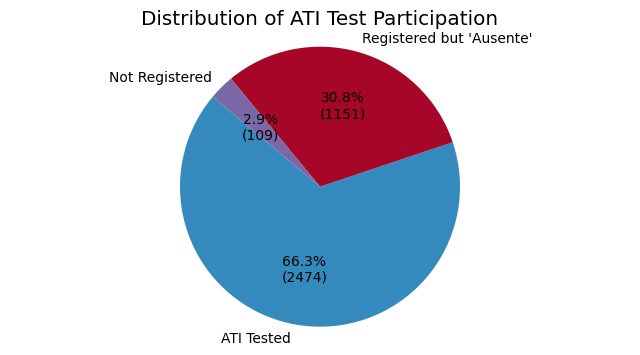

In [5]:
# Start of Analysis

# How many students did the ATI test?
num_ati_tested = df["NOTA DE ANONIMO AS BINARIO"].notna().sum()
# How many students were registered but had Ausente?
num_registered_ausente = df[df["NOTA DE ANONIMO"] == "Ausente"].shape[0]
# How many students did some Seguimientos but were not registered for the ATI test?
num_not_registered = df[df["NOTA DE ANONIMO AS BINARIO"].isna()].shape[0] - df[df["NOTA DE ANONIMO"] == "Ausente"].shape[0]

# Define a custom function to display both percentage and absolute values
def autopct_format(pct, all_values):
    absolute = int(round(pct / 100. * sum(all_values)))  # Calculate absolute value
    return f"{pct:.1f}%\n({absolute})"  # Format as percentage and absolute

# Plot as pie chart
labels = ['ATI Tested', "Registered but 'Ausente'", 'Not Registered']
sizes = [num_ati_tested, num_registered_ausente, num_not_registered]

plt.figure(figsize=(8, 4))
plt.pie(sizes, labels=labels, autopct=lambda pct: autopct_format(pct, sizes), startangle=140)
plt.title('Distribution of ATI Test Participation')
plt.axis('equal')
plt.show()

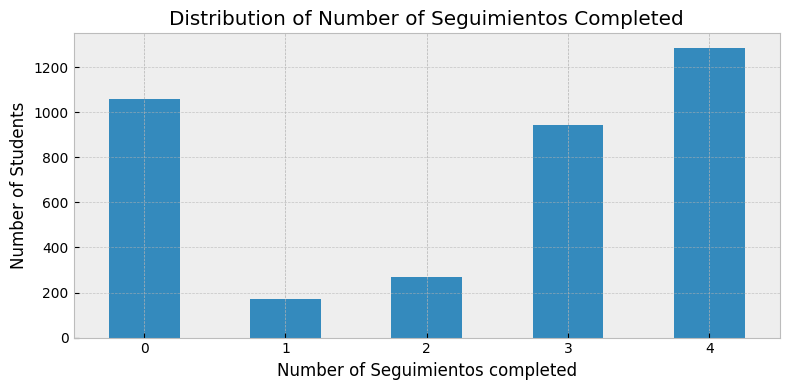

In [6]:
# Distribution of Hecho
plt.figure(figsize=(8, 4))
df["Number of Hecho"].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Number of Seguimientos Completed')
plt.xlabel('Number of Seguimientos completed')
plt.ylabel('Number of Students')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

       Ventaja       Estado  Count
0      Ventaja     Aprobado   1245
1      Ventaja  Desaprobado    688
2      Ventaja      Ausente    158
3  Sin Ventaja     Aprobado    220
4  Sin Ventaja  Desaprobado    321
5  Sin Ventaja      Ausente   1102


<Figure size 1000x600 with 0 Axes>

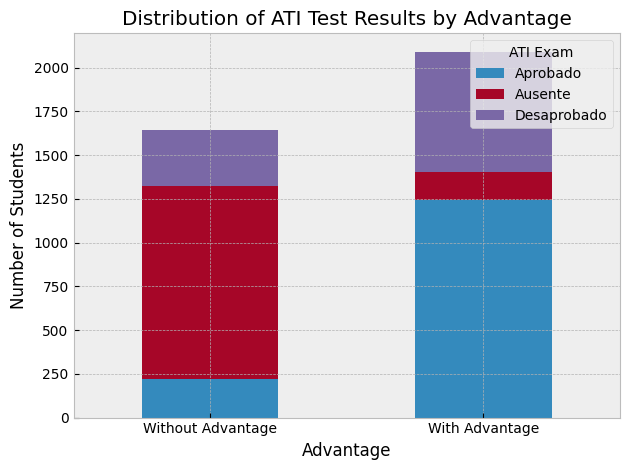

In [7]:
# Probability of passing given advantage / no advantage
num_ventaje_aprovado = df[(df["Ventaje"] == True) & (df["NOTA DE ANONIMO AS BINARIO"] == 1)].shape[0]
num_ventaje_desaprovado = df[(df["Ventaje"] == True) & (df["NOTA DE ANONIMO AS BINARIO"] == 0)].shape[0]
num_ventaje_ausente = df[(df["Ventaje"] == True) & (pd.isna(df["NOTA DE ANONIMO AS BINARIO"]))].shape[0]
num_sin_ventaje_aprovado = df[(df["Ventaje"] == False) & (df["NOTA DE ANONIMO AS BINARIO"] == 1)].shape[0]
num_sin_ventaje_desaprovado = df[(df["Ventaje"] == False) & (df["NOTA DE ANONIMO AS BINARIO"] == 0)].shape[0]
num_sin_ventaje_ausente = df[(df["Ventaje"] == False) & (pd.isna(df["NOTA DE ANONIMO AS BINARIO"]))].shape[0]

# Create a DataFrame for the stacked bar chart
data = {
    'Ventaja': ['Ventaja', 'Ventaja', 'Ventaja', 'Sin Ventaja', 'Sin Ventaja', 'Sin Ventaja'],
    'Estado': ['Aprobado', 'Desaprobado', 'Ausente', 'Aprobado', 'Desaprobado', 'Ausente'],
    'Count': [num_ventaje_aprovado, num_ventaje_desaprovado, num_ventaje_ausente,
              num_sin_ventaje_aprovado, num_sin_ventaje_desaprovado, num_sin_ventaje_ausente]
}
df_stacked = pd.DataFrame(data)

print(df_stacked)

# Plotting the stacked bar chart
# Set the colorscheme to pastel colors

plt.figure(figsize=(10, 6))
df_stacked.pivot(index='Ventaja', columns='Estado', values='Count').plot(kind='bar', stacked=True)
plt.title('Distribution of ATI Test Results by Advantage')
plt.xlabel('Advantage')
plt.ylabel('Number of Students')
plt.xticks(ticks=np.arange(2), labels=['Without Advantage', 'With Advantage'], rotation=0)
plt.xticks(rotation=0)
plt.legend(title='ATI Exam', loc='upper right')
plt.tight_layout()
plt.show()

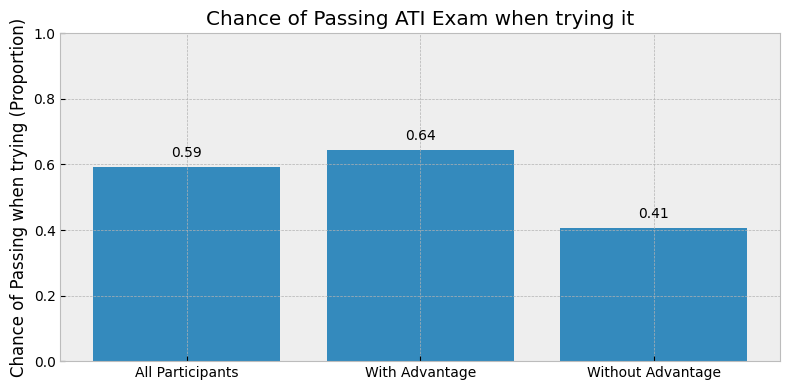

In [8]:
# get chance of aprovado for all participants
chance_aprobado = df["NOTA DE ANONIMO AS BINARIO"].sum() / df["NOTA DE ANONIMO AS BINARIO"].notna().sum()
chance_aprobado_given_ventaja = df[df["Ventaje"] == True]["NOTA DE ANONIMO AS BINARIO"].sum() / df[df["Ventaje"] == True]["NOTA DE ANONIMO AS BINARIO"].notna().sum()
chance_aprobado_given_sin_ventaja = df[df["Ventaje"] == False]["NOTA DE ANONIMO AS BINARIO"].sum() / df[df["Ventaje"] == False]["NOTA DE ANONIMO AS BINARIO"].notna().sum()

# plot the chances as bar chart
plt.figure(figsize=(8, 4))
plt.bar(['All Participants', 'With Advantage', 'Without Advantage'], 
        [chance_aprobado, chance_aprobado_given_ventaja, chance_aprobado_given_sin_ventaja])
plt.title('Chance of Passing ATI Exam when trying it')
plt.ylabel('Chance of Passing when trying (Proportion)')
plt.ylim(0, 1)
for i, v in enumerate([chance_aprobado, chance_aprobado_given_ventaja, chance_aprobado_given_sin_ventaja]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [9]:
# check correlation between nota as binary (without the nans) and ventaje (true/false)
correlation = df["NOTA DE ANONIMO AS BINARIO"].corr(df["Ventaje"], method='pearson')
print(f"Correlation between NOTA DE ANONIMO AS BINARIO and Ventaje: {correlation:.2f}")

Correlation between NOTA DE ANONIMO AS BINARIO and Ventaje: 0.20


In [10]:
# check correlation between number of points in first two seguimientos and nota
correlation_seguimiento_1 = df["SEGUIMIENTO 1"].corr(df["NOTA DE ANONIMO AS BINARIO"], method='pearson')
correlation_seguimiento_2 = df["SEGUIMIENTO 2"].corr(df["NOTA DE ANONIMO AS BINARIO"], method='pearson')
correlation_seguimiento_3 = df["SEGUIMIENTO 3"].corr(df["NOTA DE ANONIMO AS BINARIO"], method='pearson')
correlation_seguimiento_4 = df["SEGUIMIENTO 4"].corr(df["NOTA DE ANONIMO AS BINARIO"], method='pearson')
print(f"Correlation between SEGUIMIENTO 1 and NOTA DE ANONIMO AS BINARIO: {correlation_seguimiento_1:.2f}")
print(f"Correlation between SEGUIMIENTO 2 and NOTA DE ANONIMO AS BINARIO: {correlation_seguimiento_2:.2f}")
print(f"Correlation between SEGUIMIENTO 3 and NOTA DE ANONIMO AS BINARIO: {correlation_seguimiento_3:.2f}")
print(f"Correlation between SEGUIMIENTO 4 and NOTA DE ANONIMO AS BINARIO: {correlation_seguimiento_4:.2f}")

# add both first seguimientos and then check correlation with nota
df["SEGUIMIENTO 1 + 2"] = df["SEGUIMIENTO 1"] + df["SEGUIMIENTO 2"]
correlation_seguimiento_1_2 = df["SEGUIMIENTO 1 + 2"].corr(df["NOTA DE ANONIMO AS BINARIO"], method='pearson')
print(f"Correlation between SEGUIMIENTO 1 + 2 and NOTA DE ANONIMO AS BINARIO: {correlation_seguimiento_1_2:.2f}")

# add all seguimientos and then check correlation with nota
df["SEGUIMIENTO 1 + 2 + 3 + 4"] = df["SEGUIMIENTO 1"] + df["SEGUIMIENTO 2"] + df["SEGUIMIENTO 3"] + df["SEGUIMIENTO 4"]
correlation_seguimiento_all = df["SEGUIMIENTO 1 + 2 + 3 + 4"].corr(df["NOTA DE ANONIMO AS BINARIO"], method='pearson')
print(f"Correlation between SEGUIMIENTO 1 + 2 + 3 + 4 and NOTA DE ANONIMO AS BINARIO: {correlation_seguimiento_all:.2f}")

Correlation between SEGUIMIENTO 1 and NOTA DE ANONIMO AS BINARIO: 0.32
Correlation between SEGUIMIENTO 2 and NOTA DE ANONIMO AS BINARIO: 0.23
Correlation between SEGUIMIENTO 3 and NOTA DE ANONIMO AS BINARIO: 0.23
Correlation between SEGUIMIENTO 4 and NOTA DE ANONIMO AS BINARIO: 0.22
Correlation between SEGUIMIENTO 1 + 2 and NOTA DE ANONIMO AS BINARIO: 0.33
Correlation between SEGUIMIENTO 1 + 2 + 3 + 4 and NOTA DE ANONIMO AS BINARIO: 0.39


In [11]:
# separate comision group B and M and check correlation between nota as binary (without the nans) and ventaje (true/false)
df_group_b = df[df["COMISION"].str.startswith("B")]
df_group_m = df[df["COMISION"].str.startswith("M")]
print(f"Number of participants in group B: {df_group_b.shape[0]}")
print(f"Number of participants in group M: {df_group_m.shape[0]}")
print(f"Chance of passing ATI Exam in group B: {df_group_b['NOTA DE ANONIMO AS BINARIO'].sum() / df_group_b['NOTA DE ANONIMO AS BINARIO'].notna().sum():.2f}")
print(f"Chance of passing ATI Exam in group M: {df_group_m['NOTA DE ANONIMO AS BINARIO'].sum() / df_group_m['NOTA DE ANONIMO AS BINARIO'].notna().sum():.2f}")
correlation_b = df_group_b["NOTA DE ANONIMO AS BINARIO"].corr(df_group_b["Ventaje"], method='pearson')
correlation_m = df_group_m["NOTA DE ANONIMO AS BINARIO"].corr(df_group_m["Ventaje"], method='pearson')
print(f"Correlation between NOTA DE ANONIMO AS BINARIO and Ventaje for group B: {correlation_b:.2f}")
print(f"Correlation between NOTA DE ANONIMO AS BINARIO and Ventaje for group M: {correlation_m:.2f}")

Number of participants in group B: 1369
Number of participants in group M: 2365
Chance of passing ATI Exam in group B: 0.63
Chance of passing ATI Exam in group M: 0.57
Correlation between NOTA DE ANONIMO AS BINARIO and Ventaje for group B: 0.12
Correlation between NOTA DE ANONIMO AS BINARIO and Ventaje for group M: 0.32


In [12]:
# Correlation between SEGUIMIENTO 1 + 2 and NOTA DE ANONIMO AS BINARIO for both groups
correlation_b_seguimiento_1_2 = df_group_b["SEGUIMIENTO 1 + 2"].corr(df_group_b["NOTA DE ANONIMO AS BINARIO"], method='pearson')
correlation_m_seguimiento_1_2 = df_group_m["SEGUIMIENTO 1 + 2"].corr(df_group_m["NOTA DE ANONIMO AS BINARIO"], method='pearson')
print(f"Correlation between SEGUIMIENTO 1 + 2 and NOTA DE ANONIMO AS BINARIO for group B: {correlation_b_seguimiento_1_2:.2f}")
print(f"Correlation between SEGUIMIENTO 1 + 2 and NOTA DE ANONIMO AS BINARIO for group M: {correlation_m_seguimiento_1_2:.2f}")

Correlation between SEGUIMIENTO 1 + 2 and NOTA DE ANONIMO AS BINARIO for group B: 0.35
Correlation between SEGUIMIENTO 1 + 2 and NOTA DE ANONIMO AS BINARIO for group M: 0.33


In [13]:
# 4./5./6. question: regression analysis
df["group"] = df["COMISION"].apply(lambda x: "B" if x.startswith("B") else "M")
# regression analysis with group and seguimientos as independent variables and nota as dependent variable
X = df[["group", "SEGUIMIENTO 1", "SEGUIMIENTO 2", "SEGUIMIENTO 3", "SEGUIMIENTO 4"]]
# Convert group to dummy variables (rest is fine because they are numeric)
X = pd.get_dummies(X, columns=["group"], drop_first=True)  # Drop first to avoid multicollinearity
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)
X = X.fillna(0)  # Fill NaNs with 0 for regression analysis
# Ensure the dependent variable is aligned with X
y = df["NOTA DE ANONIMO AS BINARIO"].dropna()  # Dependent variable
X = X.loc[y.index]  # Align X with y after dropping NaNs
print(np.asarray(X))
print(f"X.info():\n{X.info()}")
print(f"X.shape: {X.shape}, y.shape: {y.shape}")
model = sm.OLS(y, sm.add_constant(X)).fit()  # Fit the model
print(model.summary())

# influence of being in group M
influence_group_m = model.params.get("group_M", 0)
print(f"Influence of being in group M on the ATI exam result: {influence_group_m:.2f}")

[[ 7.5  10.   10.   10.    1.  ]
 [ 7.75 10.    9.    5.75  1.  ]
 [ 8.92  9.63 10.    0.    0.  ]
 ...
 [ 6.17  8.   10.    0.    1.  ]
 [ 9.33 10.    0.    2.5   1.  ]
 [ 5.42  4.13  6.25  0.    0.  ]]
<class 'pandas.core.frame.DataFrame'>
Index: 2474 entries, 0 to 3980
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SEGUIMIENTO 1  2474 non-null   float64
 1   SEGUIMIENTO 2  2474 non-null   float64
 2   SEGUIMIENTO 3  2474 non-null   float64
 3   SEGUIMIENTO 4  2474 non-null   float64
 4   group_M        2474 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 116.0 KB
X.info():
None
X.shape: (2474, 5), y.shape: (2474,)
                                OLS Regression Results                                
Dep. Variable:     NOTA DE ANONIMO AS BINARIO   R-squared:                       0.110
Model:                                    OLS   Adj. R-squared:                  0.109
Method:               

/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_35312/2276930517.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0)  # Fill NaNs with 0 for regression analysis


In [14]:
# regression analysis with group and advantage as independent variables and nota as dependent variable
X_advantage = df[["group", "Ventaje"]]
X_advantage = pd.get_dummies(X_advantage, columns=["group", "Ventaje"], drop_first=True)  # Drop first to avoid multicollinearity
X_advantage = X_advantage.fillna(0)  # Fill NaNs with 0 for regression analysis
for col in X_advantage.select_dtypes(include='bool').columns:
    X_advantage[col] = X_advantage[col].astype(int)
# check column types
# Ensure the dependent variable is aligned with X
y_advantage = df["NOTA DE ANONIMO AS BINARIO"].dropna()  # Dependent variable
X_advantage = X_advantage.loc[y_advantage.index]  # Align X with y after dropping NaNs
model_advantage = sm.OLS(y_advantage, sm.add_constant(X_advantage)).fit()  # Fit the model
print(model_advantage.summary())

                                OLS Regression Results                                
Dep. Variable:     NOTA DE ANONIMO AS BINARIO   R-squared:                       0.055
Model:                                    OLS   Adj. R-squared:                  0.054
Method:                         Least Squares   F-statistic:                     71.86
Date:                        Mon, 09 Jun 2025   Prob (F-statistic):           4.62e-31
Time:                                18:08:09   Log-Likelihood:                -1682.9
No. Observations:                        2474   AIC:                             3372.
Df Residuals:                            2471   BIC:                             3389.
Df Model:                                   2                                         
Covariance Type:                    nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

In [15]:
# count unique carreers in ati_anonimo
print(f"There are {len(df_ati_anonimo["CARRERA"].unique())} different carreers in the ATI anonimo file.")

There are 47 different carreers in the ATI anonimo file.
